In [1]:
import math
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from matplotlib.colors import LogNorm

In [2]:
# Experiment Configurations
ROOT_DIR = "/usr/local/google/home/ttrippel/Repos/hw-fuzzing/experiments"
DATA_DIR = os.path.join(ROOT_DIR, "data")
PLOTS_DIR = os.path.join(ROOT_DIR, "plots")
AFL_EXP_BASE_NAME = "exp003-lock-runtime-afl"
COCOTB_EXP_BASE_NAME = "exp004-lock-runtime-cocotb"
AFL_MODE = "s"
NUM_STATES = [2, 4, 8, 16, 32, 64]
COMP_WIDTHS = [8, 4, 2, 1]
RUNS = range(0, 20)
STATES_LABEL = "states"
WIDTH_LABEL = "widths"
TRIALS_COMPLETED_LABEL = "trials completed"
BASE_RT_LABEL = "run time (seconds) - %d"
AVG_RT_LABEL = "avg. run time (seconds)"
MAX_RUNTIME_S = 259200 # number of seconds in 3 days
LINE_SEP = "-------------------------------------------------------------------"

In [3]:
# AFL runtime data extractor
def extract_afl_runtime(runtime_data, stats_file):
  if not os.path.exists(stats_file):
    return np.nan
  else:
    with open(stats_file, "r") as f:
      for line in f:
        line_list = line.rstrip().split(": ")
        line_list[0] = line_list[0].rstrip()
        if line_list[0] == "start_time":
          start_time = int(line_list[1])
        elif line_list[0] == "last_update":
          end_time = int(line_list[1])
        else:
          run_time = end_time - start_time
          # Adjust for sub-one-second run times
          if run_time == 0:
            run_time += 1
          return run_time
          

In [4]:
# cocotb runtime data extractor
def extract_cocotb_runtime(runtime_data, stats_file):
  if not os.path.exists(stats_file):
    return np.nan
  else:
    xml_tree = et.parse(stats_file)
    root = xml_tree.getroot()
    run_time = int(math.ceil(float(root[0].find("testcase").attrib["time"])))
    return run_time

In [5]:
# Data dictionary that will be converted to a Pandas data frame
afl_runtime_data = {
    STATES_LABEL: [],
    WIDTH_LABEL: [],
    TRIALS_COMPLETED_LABEL: [],
}
cocotb_runtime_data = {
    STATES_LABEL: [],
    WIDTH_LABEL: [],
    TRIALS_COMPLETED_LABEL: [],
}
for run in RUNS:
  afl_runtime_data[BASE_RT_LABEL % run] = []
  cocotb_runtime_data[BASE_RT_LABEL % run] = []

# Extract data from experiment files
for states in NUM_STATES:
  for width in COMP_WIDTHS:
    afl_runtime_data[STATES_LABEL].append(states)
    afl_runtime_data[WIDTH_LABEL].append(width)
    cocotb_runtime_data[STATES_LABEL].append(states)
    cocotb_runtime_data[WIDTH_LABEL].append(width)
    afl_trials_completed = 0
    cocotb_trials_completed = 0
    for run in RUNS:
      # Construct experiment data dir
      afl_exp_dir = "%s-%dstates-%dwidth-%d" % \
        (AFL_EXP_BASE_NAME, states, width, run)
      cocotb_exp_dir = "%s-%dstates-%dwidth-%d" % \
        (COCOTB_EXP_BASE_NAME, states, width, run)
      # print("Extracting data from:", exp_dir)

      # Run-time files
      fuzzer_stats_file = os.path.join(DATA_DIR, afl_exp_dir, "out/afl_%s_1/fuzzer_stats" % AFL_MODE)
      cocotb_stats_file = os.path.join(DATA_DIR, cocotb_exp_dir, "out/results.xml")

      # Get fuzzing run-times
      if states == 64 and width == 8:
        run_time = MAX_RUNTIME_S
      else:
        run_time = extract_afl_runtime(afl_runtime_data, fuzzer_stats_file)
      afl_runtime_data[BASE_RT_LABEL % run].append(run_time)
      if run_time is not np.nan: 
        afl_trials_completed += 1
      else:
        print("WARNING: FUZZER stats file does not exist: %s" % afl_exp_dir)

      # Get cocotb run-times
      if states >= 16 or states == 8 and width >= 4 or states == 4 and width == 8:
        run_time = MAX_RUNTIME_S
      else:
        run_time = extract_cocotb_runtime(cocotb_runtime_data, cocotb_stats_file)
      cocotb_runtime_data[BASE_RT_LABEL % run].append(run_time)
      if run_time is not np.nan:
        cocotb_trials_completed += 1
      # else:
        # print("WARNING: COCOTB stats file does not exist: %s" % cocotb_exp_dir)

    # update experiment progress
    afl_runtime_data[TRIALS_COMPLETED_LABEL].append(afl_trials_completed)
    cocotb_runtime_data[TRIALS_COMPLETED_LABEL].append(cocotb_trials_completed)

# Convert data dictionaries to data frames
afl_runtime_df_long = pd.DataFrame.from_dict(afl_runtime_data)
cocotb_runtime_df_long = pd.DataFrame.from_dict(cocotb_runtime_data)

# Compute averages of runs as new column, skipping NaN values
# AFL
afl_rt_row_means = afl_runtime_df_long.iloc[:,3:].mean(axis=1, skipna=True).round(0)
afl_rt_row_means = afl_rt_row_means.fillna(1).astype(int)
afl_runtime_df_long[AVG_RT_LABEL] = afl_rt_row_means
# cocotb
cocotb_rt_row_means = cocotb_runtime_df_long.iloc[:,3:].mean(axis=1, skipna=True).round(0)
cocotb_rt_row_means = cocotb_rt_row_means.fillna(1).astype(int)
cocotb_runtime_df_long[AVG_RT_LABEL] = cocotb_rt_row_means

# Convert data frame to wide format
afl_runtime_df_wide = afl_runtime_df_long.pivot(\
    index=WIDTH_LABEL, \
    columns=STATES_LABEL, \
    values=AVG_RT_LABEL)
cocotb_runtime_df_wide = cocotb_runtime_df_long.pivot(\
    index=WIDTH_LABEL, \
    columns=STATES_LABEL, \
    values=AVG_RT_LABEL)

# Create data frames to show experiment progress
afl_progress_df_wide = afl_runtime_df_long.pivot(\
    index=WIDTH_LABEL, \
    columns=STATES_LABEL, \
    values=TRIALS_COMPLETED_LABEL)
cocotb_progress_df_wide = cocotb_runtime_df_long.pivot(\
    index=WIDTH_LABEL, \
    columns=STATES_LABEL, \
    values=TRIALS_COMPLETED_LABEL)

# Compute min/max run-times
# AFL
afl_min_runtime = afl_rt_row_means.min()
afl_max_runtime = afl_rt_row_means.max()
print("AFL - Min Run-time:", afl_min_runtime)
print("AFL - Max Run-time:", afl_max_runtime)
print(LINE_SEP)
# cocotb
cocotb_min_runtime = cocotb_rt_row_means.min()
cocotb_max_runtime = cocotb_rt_row_means.max()
print("cocotb - Min Run-time:", cocotb_min_runtime)
print("cocotb - Max Run-time:", cocotb_max_runtime)
print(LINE_SEP)
# overall
overall_min_runtime = min(afl_min_runtime, cocotb_min_runtime)
overall_max_runtime = max(afl_max_runtime, cocotb_max_runtime)
print("Overall - Min Run-time:", overall_min_runtime)
print("Overall - Max Run-time:", overall_max_runtime)
print(LINE_SEP)

# Print experiment progress
print("AFL progress:")
print(afl_progress_df_wide)
print(LINE_SEP)
print("cocotb progress:")
print(cocotb_progress_df_wide)

AFL - Min Run-time: 1
AFL - Max Run-time: 259200
-------------------------------------------------------------------
cocotb - Min Run-time: 1
cocotb - Max Run-time: 259200
-------------------------------------------------------------------
Overall - Min Run-time: 1
Overall - Max Run-time: 259200
-------------------------------------------------------------------
AFL progress:
states  2   4   8   16  32  64
widths                        
1       20  20  20  20  19  19
2       20  20  20  20  20  20
4       20  20  20  20  19  20
8       20  20  20  20  18  20
-------------------------------------------------------------------
cocotb progress:
states  2   4   8   16  32  64
widths                        
1        3   3   3  20  20  20
2        3   3   3  20  20  20
4        3   3  20  20  20  20
8        3  20  20  20  20  20


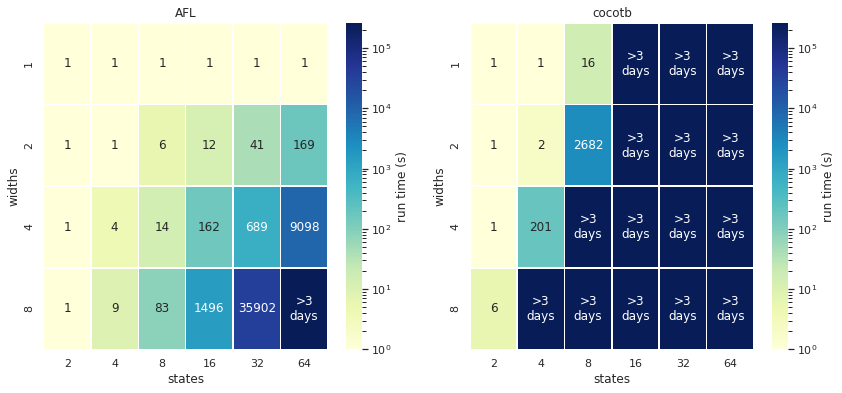

In [7]:
# Draw a heatmap with the numeric values in each cell
sns.set()
FIG_WIDTH = 14
FIG_HEIGHT = 6
heatmap, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

# Create heatmap colorbar scale
min_log = math.floor(math.log10(overall_min_runtime))
max_log = math.ceil(math.log10(overall_max_runtime))
cbar_ticks = [math.pow(10, i) for i in range(min_log, max_log + 1)]

# Create heatmaps
sns.heatmap(afl_runtime_df_wide, \
            annot=True, \
            fmt="d", \
            linewidths=.5, \
            ax=ax1, \
            cmap="YlGnBu", \
            norm=LogNorm(), \
            cbar_kws={"ticks": cbar_ticks, "label": "run time (s)"})
sns.heatmap(cocotb_runtime_df_wide, \
            annot=True, \
            fmt="d", \
            linewidths=.5, \
            ax=ax2, \
            cmap="YlGnBu", \
            norm=LogNorm(), \
            cbar_kws={"ticks": cbar_ticks, "label": "run time (s)"})
ax1.set_title("AFL")
ax2.set_title("cocotb")

# set text of cells that did not finish
for text in ax1.texts:
    if text.get_text() == str(MAX_RUNTIME_S):
        text.set_text('>3\ndays')
for text in ax2.texts:
    if text.get_text() == str(MAX_RUNTIME_S):
        text.set_text('>3\ndays')

# save the figure to a PDF
plt.savefig(os.path.join(PLOTS_DIR, "exp005_lock_complexity_vs_runtime.pdf"), format="PDF")